In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score,
    confusion_matrix
)
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
train_df = pd.read_csv('C:\\Users\\fabrizio natali\\Desktop\\dissertation\\train_data.csv')

In [3]:
df = pd.read_csv('C:\\Users\\fabrizio natali\\Desktop\\dissertation\\train_data.csv')
display(df.head())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Calculate the percentage of missing values in each column
missing_percentage = df.isnull().sum() / len(df) * 100

# Get the columns with more than 20% missing data
columns_to_drop = missing_percentage[missing_percentage > 20].index

# Drop the columns from the DataFrame
df_cleaned = df.drop(columns=columns_to_drop)
display(df_cleaned.head())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Handle categorical variables and missing values for XGBoost
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [6]:
# Encode target variable (required for XGBoost)
# Fix: y was not previously defined. Derive it from df_cleaned if available, else from df.
target_encoder = LabelEncoder()
target_series = df_cleaned['TARGET'] if 'df_cleaned' in globals() else df['TARGET']
y = target_encoder.fit_transform(target_series.astype(str))

In [7]:
def read_data(file_name):
  df = pd.read_csv(file_name)  # Use the file_name parameter
  print(file_name, 'has', len(df), 'data points')
  return df

In [8]:
# Ensure feature matrix X exists before selecting dtypes
if 'X' not in globals():
	base_df = df_cleaned if 'df_cleaned' in globals() else df
	if 'TARGET' in base_df.columns:
		X = base_df.drop(columns=['TARGET'])
	else:
		X = base_df.copy()

# Separate numeric and categorical columns
numeric_cols = X.select_dtypes(include=['number']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

print(f'Initialized X with shape {X.shape}')
print(f'Numeric columns: {len(numeric_cols)}, Categorical columns: {len(categorical_cols)}')

Initialized X with shape (307511, 71)
Numeric columns: 60, Categorical columns: 11


In [9]:
# Ensure numeric_cols and X are defined (imputation handled in later cell)
if 'numeric_cols' not in globals() or 'X' not in globals():
    base_df = df_cleaned if 'df_cleaned' in globals() else df
    X = base_df.drop(columns=['TARGET']) if 'TARGET' in base_df.columns else base_df.copy()
    numeric_cols = X.select_dtypes(include=['number']).columns

print(f'Numeric columns available: {len(numeric_cols)}')
# Note: Actual numeric imputation is performed in the subsequent cell (index 9).

Numeric columns available: 60


In [10]:
# Handle missing values in numeric columns
# Ensure feature matrix X and helper lists exist before imputation
if 'X' not in globals() or 'numeric_cols' not in globals():
    base_df = df_cleaned if 'df_cleaned' in globals() else df
    X = base_df.drop(columns=['TARGET']) if 'TARGET' in base_df.columns else base_df.copy()
    numeric_cols = X.select_dtypes(include=['number']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns

if len(numeric_cols) > 0:
    numeric_imputer = SimpleImputer(strategy='mean')
    # Transform and assign back to maintain DataFrame structure
    X.loc[:, numeric_cols] = numeric_imputer.fit_transform(X[numeric_cols])

print(f'Numeric columns imputed: {len(numeric_cols)}')

Numeric columns imputed: 60


In [11]:
# Handle categorical columns (encode them)
if len(categorical_cols) > 0:
    for col in categorical_cols:
        # Fill missing values with mode or 'unknown'
        X[col] = X[col].fillna('unknown')
        # Label encode categorical variables
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

print(f"Dataset shape: {X.shape}")
print(f"Number of numeric features: {len(numeric_cols)}")
print(f"Number of categorical features: {len(categorical_cols)}")
print(f"Target distribution:")
unique, counts = np.unique(y, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")

Dataset shape: (307511, 71)
Number of numeric features: 60
Number of categorical features: 11
Target distribution:
Class 0: 282686 samples
Class 1: 24825 samples


In [12]:
# Build df_encoded from already prepared X and y if it does not exist.
# This avoids NameError when later cells expect df_encoded.
if 'df_encoded' not in globals():
	# Use existing X (features after preprocessing) and y (encoded target)
	# Reconstruct a combined DataFrame for downstream cells that expect df_encoded.
	df_encoded = X.copy()
	# Insert TARGET as first column (optional ordering)
	if 'TARGET' not in df_encoded.columns:
		df_encoded.insert(0, 'TARGET', y)
	print("df_encoded was created from existing X and y.")
else:
	print("df_encoded already exists. No recreation performed.")

print(f"df_encoded shape: {df_encoded.shape}")
print(f"Number of features (excluding TARGET): {df_encoded.shape[1] - 1}")
print(f"Number of samples: {df_encoded.shape[0]}")
print("Target distribution:")
print(df_encoded['TARGET'].value_counts())

df_encoded was created from existing X and y.
df_encoded shape: (307511, 72)
Number of features (excluding TARGET): 71
Number of samples: 307511
Target distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64


In [13]:
# Train-test split (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Model
model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
model.fit(X_train, y_train)


C:\Users\fabrizio natali\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:12:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [15]:

# For multiclass, we need to handle metrics differently
n_classes = len(target_encoder.classes_)
print(f"Number of classes: {n_classes}")

Number of classes: 2


In [16]:

# Metrics
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

In [17]:
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, brier_score_loss

# Get predicted probabilities for positive class
y_prob = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)
confusion = confusion_matrix(y_test, y_pred)
brier_score = brier_score_loss(y_test, y_prob)

print("Test Set Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Average Precision Score:", average_precision)
print("Confusion Matrix:")
print(confusion)
print("Brier Score:", brier_score)

Test Set Accuracy: 0.9192071931450498
Precision: 0.4738219895287958
Recall: 0.036573045059608005
F1 Score: 0.06790470830988557
ROC AUC Score: 0.742540631204563
Average Precision Score: 0.22568207235722015
Confusion Matrix:
[[56353   201]
 [ 4768   181]]
Brier Score: 0.06875180042128741


In [18]:
# Separate features (X) and target (y) from the real dataset
X_real = df_encoded.drop('TARGET', axis=1)
y_real = df_encoded['TARGET']

# Split the real data into training and testing sets
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

# Create and train a XGBClassifier on the real data
model_real = XGBClassifier(random_state=42)
model_real.fit(X_train_real, y_train_real)

# Create feature importances using the trained model
column_names = df_encoded.drop('TARGET', axis=1).columns.tolist()
feature_importances = pd.Series(model_real.feature_importances_, index=column_names)

# Sort the importances in descending order and display the top 10
top_features = feature_importances.sort_values(ascending=False).head(10)
print("Top 10 most important features:")
print(top_features)

Top 10 most important features:
EXT_SOURCE_3                   0.074229
EXT_SOURCE_2                   0.060713
CODE_GENDER                    0.047426
NAME_EDUCATION_TYPE            0.038825
FLAG_DOCUMENT_3                0.033395
FLAG_OWN_CAR                   0.026937
NAME_CONTRACT_TYPE             0.025683
NAME_INCOME_TYPE               0.023540
AMT_GOODS_PRICE                0.022464
REGION_RATING_CLIENT_W_CITY    0.022382
dtype: float32


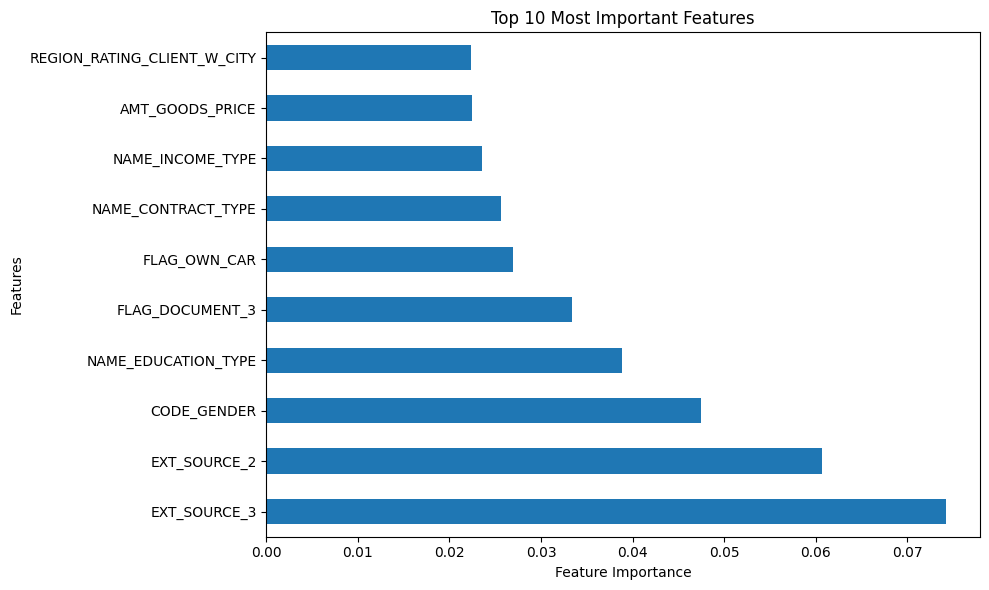

In [19]:
# Visualize feature importances
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

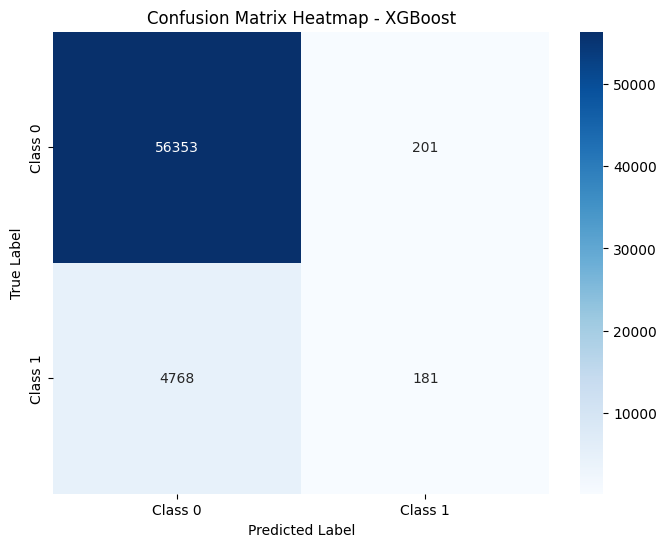

Confusion Matrix:
[[56353   201]
 [ 4768   181]]


In [20]:
# Make predictions for visualization using the main model
y_pred_viz = model.predict(X_test)

# Create confusion matrix for the real data
from sklearn.metrics import confusion_matrix
import seaborn as sns

confusion_viz = confusion_matrix(y_test, y_pred_viz)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_viz, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix Heatmap - XGBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("Confusion Matrix:")
print(confusion_viz)

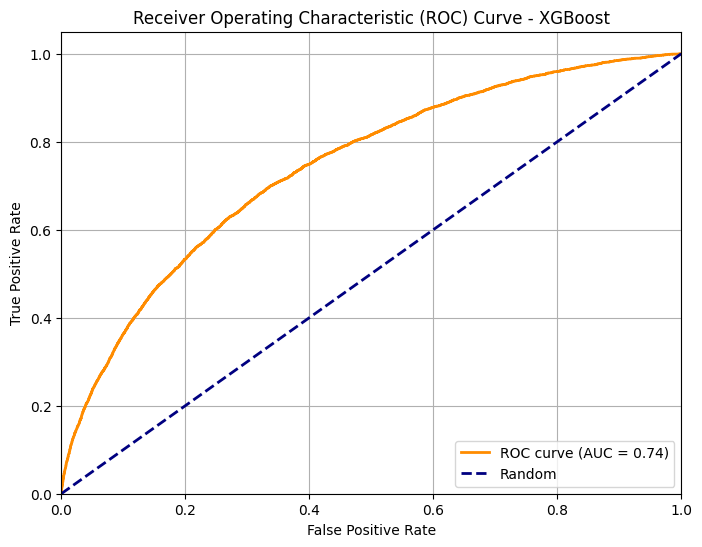

In [21]:
# ROC Curve visualization using main model
from sklearn.metrics import roc_curve, auc

# Get prediction probabilities for ROC curve using main model
y_pred_proba_viz = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_viz)
roc_auc_viz = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_viz:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

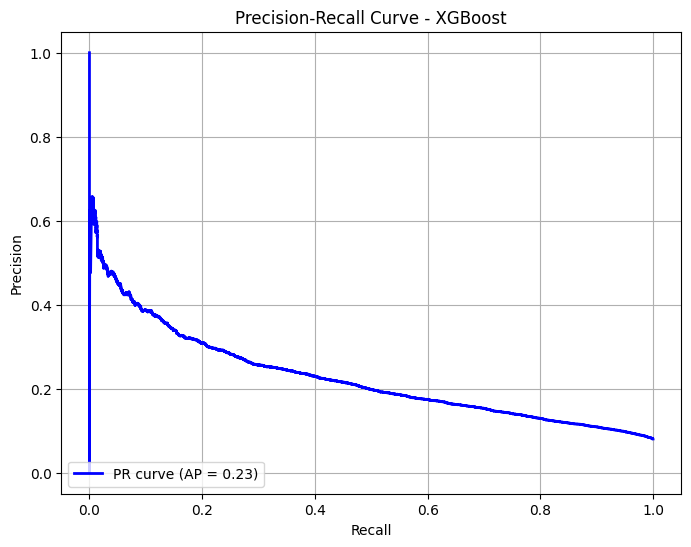

In [22]:
# Precision-Recall Curve using main model
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_viz, recall_viz, _ = precision_recall_curve(y_test, y_pred_proba_viz)
avg_precision_viz = average_precision_score(y_test, y_pred_proba_viz)

plt.figure(figsize=(8, 6))
plt.plot(recall_viz, precision_viz, color='blue', lw=2, label=f'PR curve (AP = {avg_precision_viz:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - XGBoost')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

In [23]:
# Enhanced Visualizations for XGBoost Classifier
import numpy as np
from sklearn.metrics import roc_curve, precision_recall_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

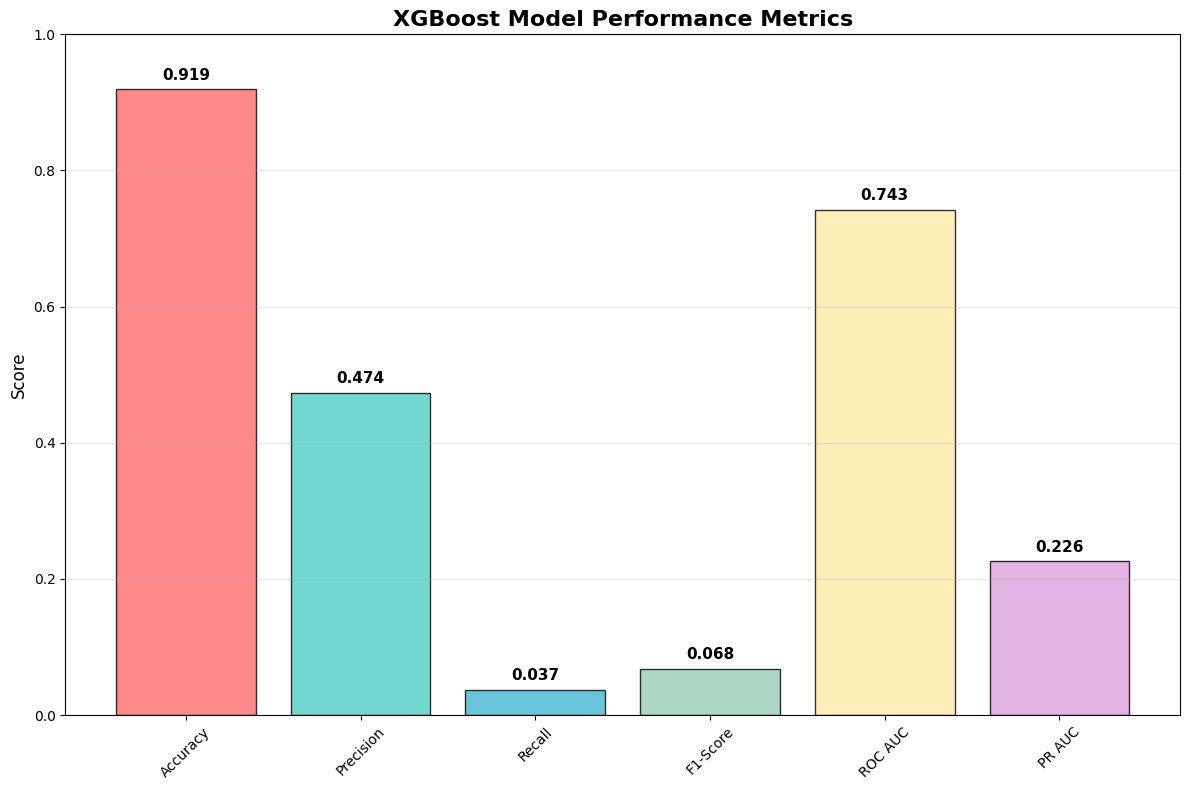

In [24]:
#Performance Metrics Bar Chart
plt.figure(figsize=(12, 8))
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'PR AUC']

# Map to existing computed metric variables
acc_val = acc if 'acc' in globals() else accuracy
prec_val = precision if 'precision' in globals() else None
rec_val = recall if 'recall' in globals() else None
f1_val = f1 if 'f1' in globals() else None
roc_auc_val = roc_auc if 'roc_auc' in globals() else None
pr_auc_val = average_precision if 'average_precision' in globals() else None

metrics_values = [acc_val, prec_val, rec_val, f1_val, roc_auc_val, pr_auc_val]

# Replace Nones with 0 and annotate as N/A in labels
labels = []
for name, val in zip(metrics_names, metrics_values):
    if val is None:
        labels.append(f'{name} (N/A)')
    else:
        labels.append(name)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
bars = plt.bar(labels, [0 if v is None else v for v in metrics_values], color=colors, alpha=0.8, edgecolor='black', linewidth=1)
plt.title('XGBoost Model Performance Metrics', fontsize=16, fontweight='bold')
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars, [0 if v is None else v for v in metrics_values]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("=" * 60)

In [25]:
%pip install shap
import shap

# SHAP Analysis for Model Explainability
# Create SHAP explainer for the trained model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the test set (using a sample for performance)
# Use a subset of test data for faster computation
sample_size = min(100, len(X_test))
X_test_sample = X_test.iloc[:sample_size]

# Ensure y_test_sample is a pandas Series (needed for .iloc in later cells)
if isinstance(y_test, np.ndarray):
    y_test_sample = pd.Series(y_test[:sample_size], name='TARGET')
else:
    y_test_sample = y_test.iloc[:sample_size]

print(f"Computing SHAP values for {sample_size} test samples...")
shap_values = explainer.shap_values(X_test_sample)

print(f"SHAP values computed successfully!")
print(f"Type of shap_values: {type(shap_values)}")
print(f"SHAP values shape: {shap_values.shape}")
print(f"Base value: {explainer.expected_value}")
print(f"Sample features shape: {X_test_sample.shape}")

# For binary classification, SHAP values have shape (n_samples, n_features, n_classes)
# We need to extract the SHAP values for class 1 (positive class)
if len(shap_values.shape) == 3 and shap_values.shape[2] == 2:
    # Binary classification case: use class 1 (positive class)
    shap_values_to_use = shap_values[:, :, 1]  # Shape: (n_samples, n_features)
    base_value = explainer.expected_value[1]
    print(f"Using class 1 SHAP values with shape: {shap_values_to_use.shape}")
elif len(shap_values.shape) == 2:
    # Already 2D case
    shap_values_to_use = shap_values
    base_value = explainer.expected_value if np.isscalar(explainer.expected_value) else explainer.expected_value[0]
    print(f"Using 2D SHAP values with shape: {shap_values_to_use.shape}")
else:
    print(f"Unexpected SHAP values shape: {shap_values.shape}")
    # Fallback: use the first output
    shap_values_to_use = shap_values.reshape(shap_values.shape[0], -1)
    base_value = explainer.expected_value[0] if hasattr(explainer.expected_value, '__len__') else explainer.expected_value

print(f"Base value (expected model output): {base_value:.4f}")

# Calculate feature importance based on mean absolute SHAP values
# Shape should be (n_samples, n_features) -> mean over samples -> (n_features,)
mean_shap_importance = np.abs(shap_values_to_use).mean(axis=0)

print(f"SHAP importance shape: {mean_shap_importance.shape}")
print(f"Number of features: {len(X_test_sample.columns)}")

# Verify shapes match
if len(mean_shap_importance) == len(X_test_sample.columns):
    print("✓ Shapes match perfectly!")
else:
    print(f"⚠ Shape mismatch! SHAP: {len(mean_shap_importance)}, Features: {len(X_test_sample.columns)}")

# Create DataFrame with feature names and SHAP importance
feature_importance_shap = pd.DataFrame({
    'feature': X_test_sample.columns,
    'shap_importance': mean_shap_importance
}).sort_values('shap_importance', ascending=False)

print("\nTop 10 Most Important Features (SHAP-based):")
print(feature_importance_shap.head(10))

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Computing SHAP values for 100 test samples...
SHAP values computed successfully!
Type of shap_values: <class 'numpy.ndarray'>
SHAP values shape: (100, 71)
Base value: -2.5558271408081055
Sample features shape: (100, 71)
Using 2D SHAP values with shape: (100, 71)
Base value (expected model output): -2.5558
SHAP importance shape: (71,)
Number of features: 71
✓ Shapes match perfectly!

Top 10 Most Important Features (SHAP-based):
                feature  shap_importance
39         EXT_SOURCE_3         0.417756
38         EXT_SOURCE_2         0.330544
9       AMT_GOODS_PRICE         0.298991
7            AMT_CREDIT         0.238189
2           CODE_GENDER         0.166170
12  NAME_EDUCATION_TYPE         0.135932
8           AMT_ANNUITY         0.122675
17        DAYS_EMPLOYED         0.113844
16           DAYS_BIRTH         0.113075
3          FLAG_OWN_CAR         0.101872


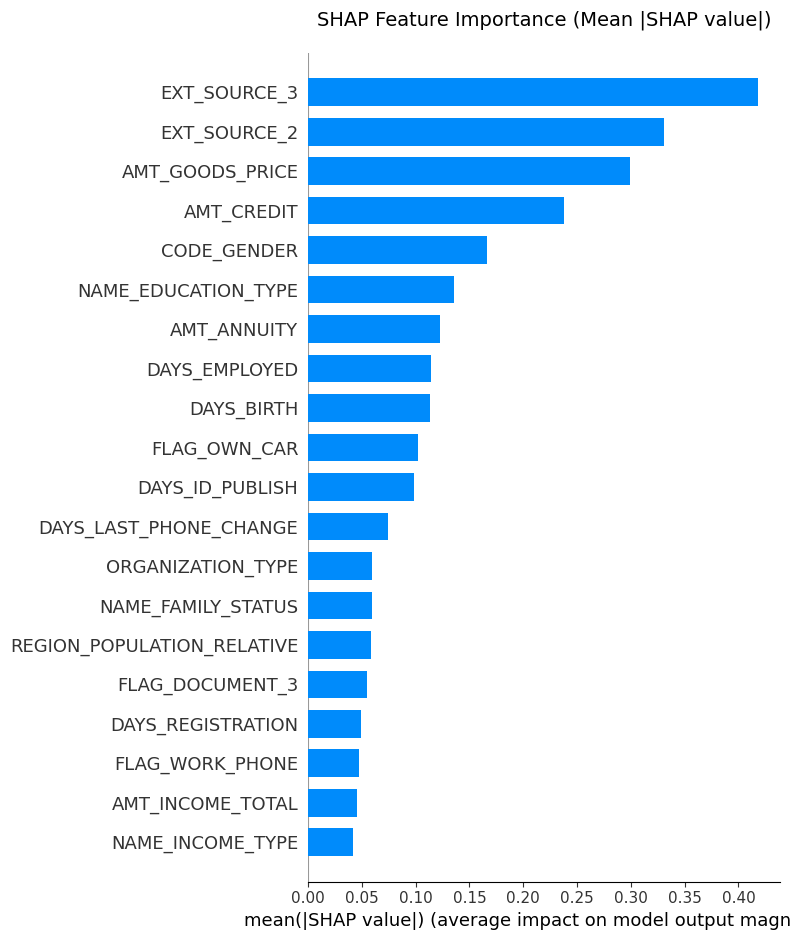

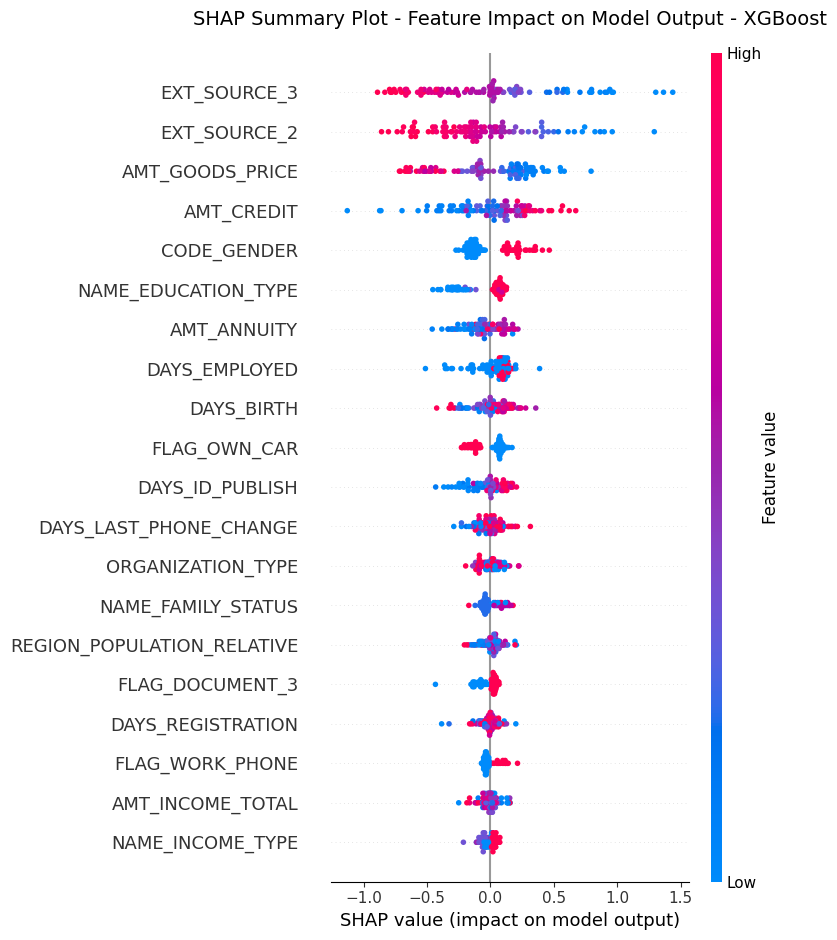

In [26]:
# SHAP Summary Plot - Shows feature importance and impact direction
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_to_use, X_test_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Mean |SHAP value|)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# SHAP Summary Plot with feature values
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values_to_use, X_test_sample, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Model Output - XGBoost', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


=== SAMPLE 1 (Index 0) ===
Actual label: 0
Predicted probability (class 1): 0.2856


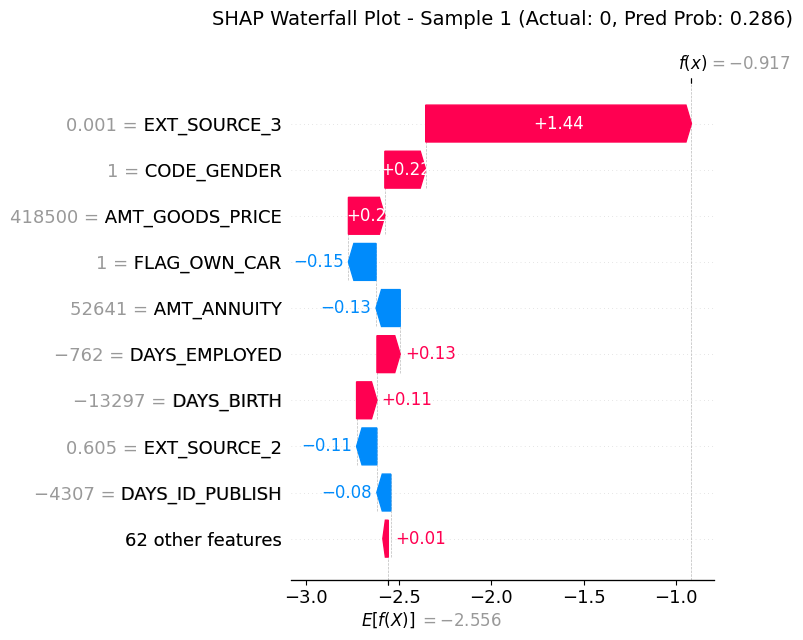


=== SAMPLE 2 (Index 1) ===
Actual label: 0
Predicted probability (class 1): 0.0300


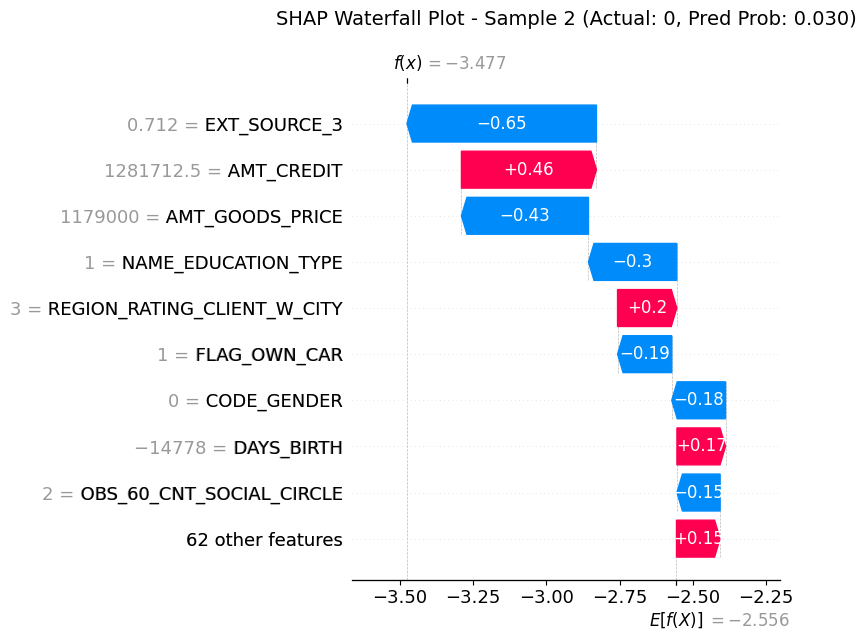


=== SAMPLE 3 (Index 2) ===
Actual label: 0
Predicted probability (class 1): 0.0751


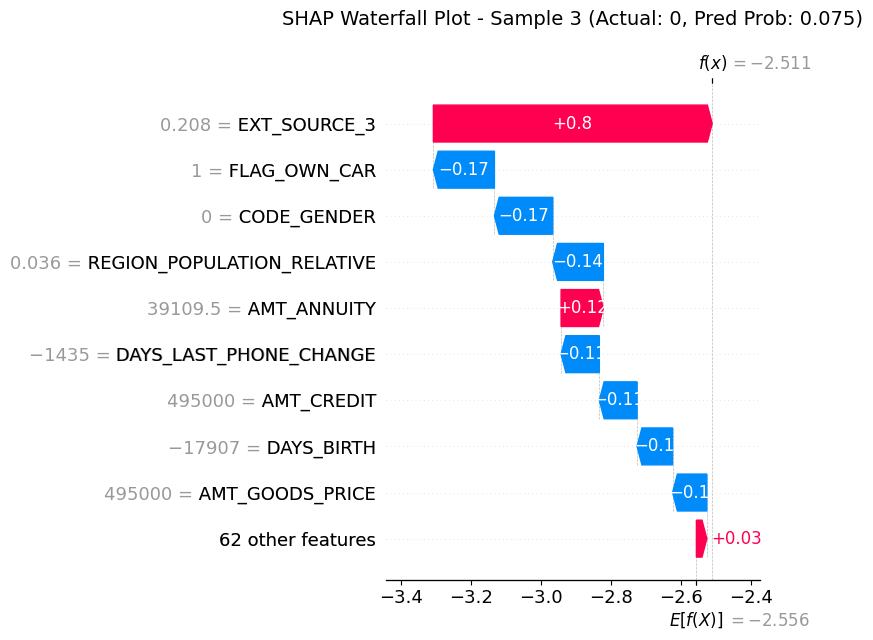

In [27]:
# SHAP Waterfall Plot - Explain individual predictions
# Select a few interesting samples to explain
sample_indices = [0, 1, 2]  # First three samples

for i, idx in enumerate(sample_indices):
    actual_label = y_test_sample.iloc[idx]
    predicted_prob = model.predict_proba(X_test_sample.iloc[[idx]])[0, 1]
    
    print(f"\n=== SAMPLE {i+1} (Index {idx}) ===")
    print(f"Actual label: {actual_label}")
    print(f"Predicted probability (class 1): {predicted_prob:.4f}")
    
    # Create waterfall plot
    plt.figure(figsize=(12, 8))
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values_to_use[idx], 
            base_values=base_value, 
            data=X_test_sample.iloc[idx],
            feature_names=X_test_sample.columns.tolist()
        ),
        show=False
    )
    plt.title(f'SHAP Waterfall Plot - Sample {i+1} (Actual: {actual_label}, Pred Prob: {predicted_prob:.3f})', 
              fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()